In [1]:
import numpy as np
import pandas as pd

## Creating sine dataframe here!

# Define time vector (e.g., from 0 to 10 seconds, with 1000 points)
time = np.linspace(0, 10, 1000)

# Define sine wave parameters
frequency = 1.5  # Hz (change this to adjust the wave frequency)
amplitude = 2.3547  # unitless (change this to adjust the wave amplitude)

# Generate sine wave values
sine_wave = amplitude * np.sin(2 * np.pi * frequency * time)

# Create DataFrame
sine_df = pd.DataFrame({
    'Time (seconds)': time,
    'Sine Amplitude': sine_wave
})

# Show the first few rows
print(sine_df.head())


   Time (seconds)  Sine Amplitude
0         0.00000        0.000000
1         0.01001        0.221818
2         0.02002        0.441663
3         0.03003        0.657580
4         0.04004        0.867649


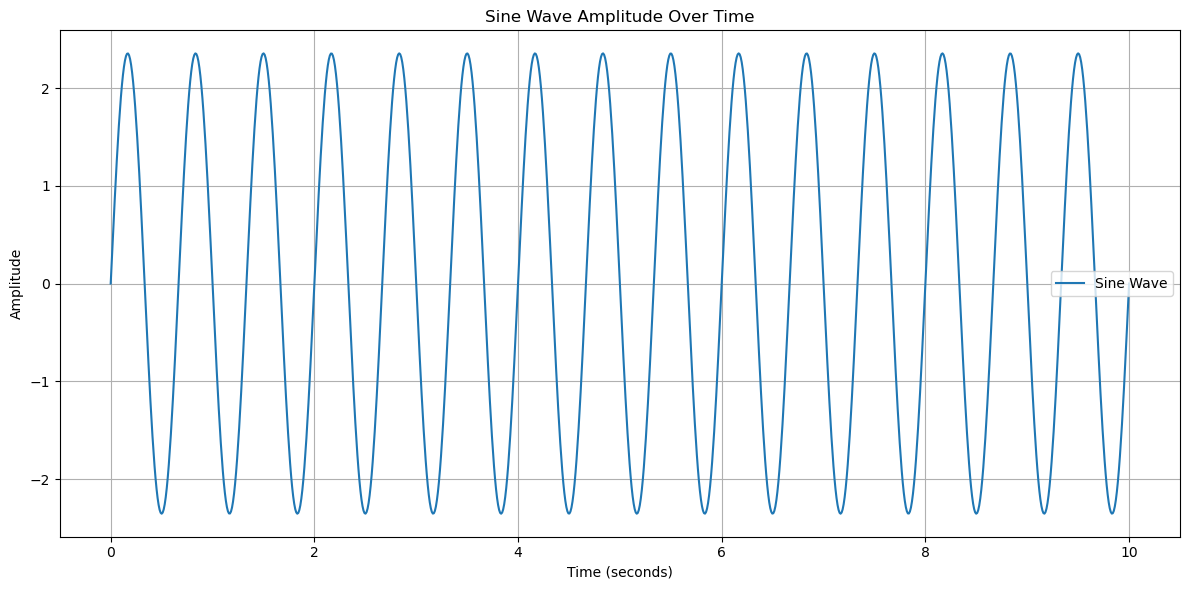

In [2]:
## This is my sine wave data plot

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(sine_df['Time (seconds)'], sine_df['Sine Amplitude'], label='Sine Wave')
plt.title('Sine Wave Amplitude Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [3]:
## Sequences
## Creating sequences for time series analysis
## Splitting the data into sequences for time series analysis
import numpy as np
def create_multistep_sequences(data, input_steps=30, output_steps=50):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps + 1):
        X.append(data[i:i + input_steps])
        y.append(data[i + input_steps:i + input_steps + output_steps])
    return np.array(X), np.array(y)

features =sine_df["Sine Amplitude"].values

X10, y10 = create_multistep_sequences(features)


In [4]:
import numpy as np
import tensorflow as tf

print("NumPy version:", np.__version__)
print("TensorFlow version:", tf.__version__)


2025-06-06 09:37:33.236343: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-06 09:37:33.319680: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-06 09:37:33.859602: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-06 09:37:33.863084: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-06 09:37:36.087096: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

NumPy version: 1.23.5
TensorFlow version: 2.13.0


In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

# ------------------------
# Model Configuration
# ------------------------

input_steps = 30      # Number of time steps in the input sequence
output_steps = 50     # Number of time steps to predict
input_dim = 1         # Number of features per time step (e.g., just sine amplitude)

# ------------------------
# Encoder
# ------------------------

# Define input shape: a sequence of 30 time steps, each with 1 feature - the sine amplitude
# This will be the input to the encoder
encoder_inputs = Input(shape=(input_steps, input_dim))  # shape: (None, 30, 1)

# LSTM processes the sequence and outputs a single latent vector (size 64)
encoder_lstm = LSTM(64, return_sequences=False)(encoder_inputs)  # shape: (None, 64)

## -------------------------------------
## Right now I have a long vector of 64 features but my decoder expects a sequence of 50 time steps.
##

# ------------------------
# Decoder
# ------------------------

# Repeat the latent vector 50 times to prepare for decoder input
# shape becomes (None, 50, 64)
decoder_repeated = RepeatVector(output_steps)(encoder_lstm)

# LSTM processes the repeated context and returns a full sequence of 50 steps
# Each step still has 64 features internally
decoder_lstm = LSTM(64, return_sequences=True)(decoder_repeated)  # shape: (None, 50, 64)

# Apply a Dense layer to each of the 50 time steps to predict 1 value per step
# Final output shape: (None, 50, 1)
decoder_outputs = Dense(input_dim)(decoder_lstm)

# ------------------------
# Define and Compile Model
# ------------------------

# Build the full model from encoder input to decoder output
LSTMmodel = Model(inputs=encoder_inputs, outputs=decoder_outputs)

# Compile using Mean Squared Error loss, standard for regression
LSTMmodel.compile(optimizer='adam', loss='mse')

# Print summary of architecture
LSTMmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 repeat_vector (RepeatVecto  (None, 50, 64)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 50, 64)            33024     
                                                                 
 dense (Dense)               (None, 50, 1)             65        
                                                                 
Total params: 49985 (195.25 KB)
Trainable params: 49985 (195.25 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________

In [ ]:
## Train the model
history = LSTMmodel.fit(X10, y10, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 2.4037

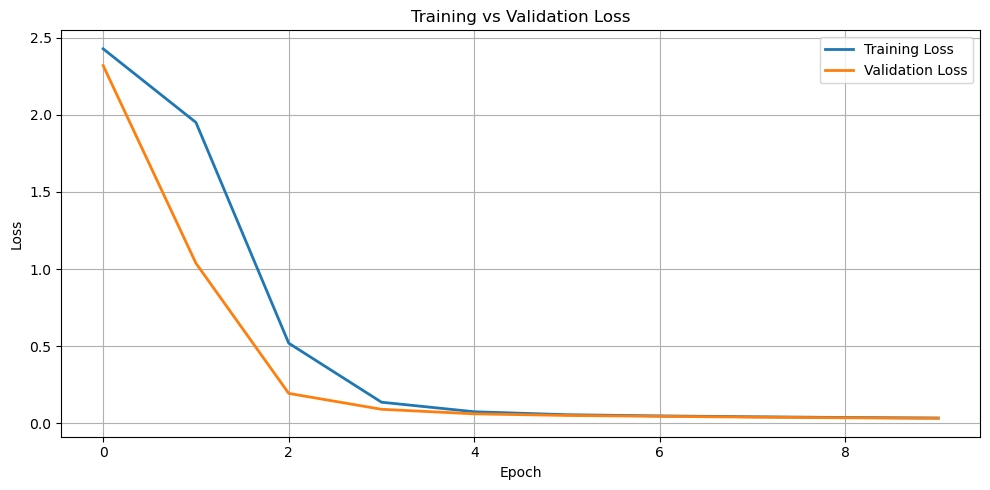

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 361ms/step


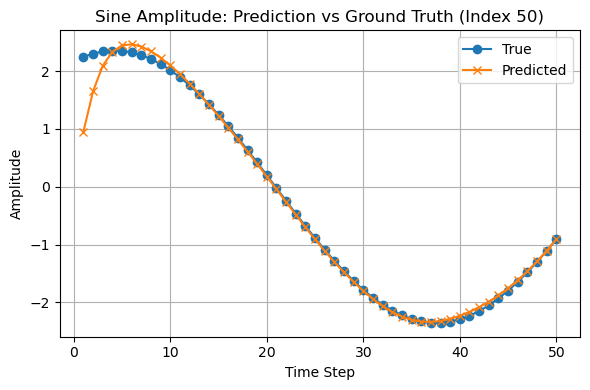

1/1 [==============================] - 0s 25ms/step


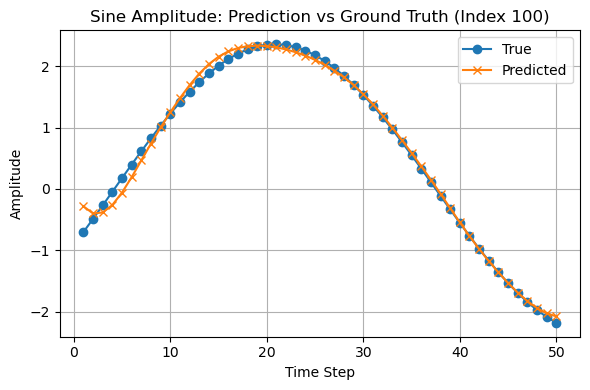

1/1 [==============================] - 0s 23ms/step


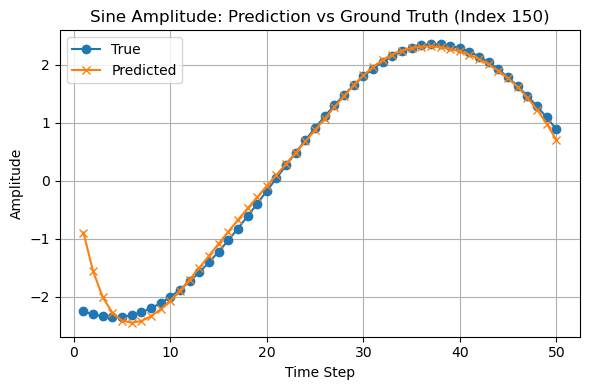

1/1 [==============================] - 0s 20ms/step


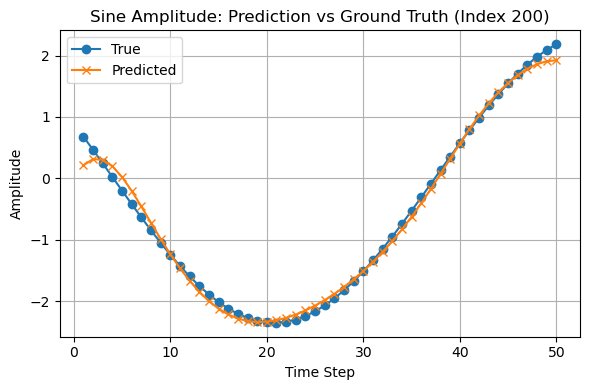

1/1 [==============================] - 0s 16ms/step


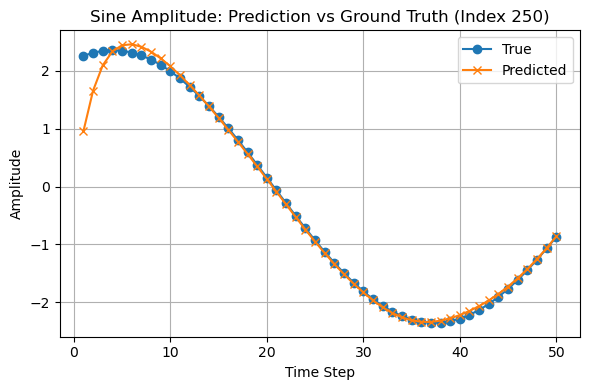

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the last input sequence and target
for i in [50, 100, 150, 200, 250]:
    index = i
    pred = LSTMmodel.predict(X10[index:index+1])  # shape: (1, 50, 1)
    true = y10[index]                # shape: (50, 1)

    # Plotting
    time_steps = np.arange(1, 51)

    plt.figure(figsize=(6, 4))
    plt.plot(time_steps, true, label='True', marker='o')                  # 1D
    plt.plot(time_steps, pred[0, :, 0], label='Predicted', marker='x')   # 2D
    plt.title(f'Sine Amplitude: Prediction vs Ground Truth (Index {index})')
    plt.xlabel('Time Step')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Appendix 